# OMNIFIT: L-band fitting

The code snippet below shows how one might go about fitting a target spectrum with an empirically acquired spectrum and a Gaussian function, and to both export the raw fit results and plot them.

The target spectrum data is assumed to originate from a file which consists of two columns of data. 
The first column contains the wavelength and the second column contains the optical depth of an observed spectrum. 
The empirical spectrum being fitted to this, by contrast, is assumed to be a file containing set of data describing the complex refractive index of an ice. The first column of this file contains the frequency of the spectrum (in reciprocal wavenumbers), and the second and third columns containing the real and imaginary parts of the complex 
refractive index.

The full documentation of OMNIFIT can be found here: https://ricemunk.github.io/omnifit/doc/overview.htmrefractive and http://oro.open.ac.uk/61309/

Adapted from Aleksi Suutarinen, 2015. 

# Install/import the various components needed for the full fit

In [22]:
import numpy as np
import omnifit
from omnifit.spectrum import AbsorptionSpectrum,CDESpectrum
from omnifit.utils import unit_od
import astropy.units as u
from omnifit.fitter import Fitter
from lmfit import Parameters
import matplotlib.pyplot as plt

Read the spectrum data from the two files which contain the target spectrum and the complex refractive index spectrum. Note that omnifit only accepts the optical depth spectrum and the frequency has to be in reciprocal wavenumbers. 

In [23]:
#obs_wl,obs_od = np.loadtxt('specs/obsdata.csv',dtype=float,delimiter=',',usecols=(0,1)).T
obs_wl,obs_od = np.loadtxt('Removed_silicate_spectrum.txt',dtype=float,usecols=(0,1)).T
lab_wn,lab_n,lab_k = np.loadtxt('nk/labdata.csv',dtype=float,delimiter=',',usecols=(0,1,2)).T

Initialise the target spectrum as an absorption spectrum and the CDE-corrected spectrum using the data read in the cell above. 

In [24]:
obs_spec = AbsorptionSpectrum(obs_wl*u.micron,obs_od*unit_od,specname='Observed data')
lab_spec = CDESpectrum(lab_wn,lab_n+lab_k*1j,specname='Laboratory data')

/Users/willrocha/ice_fitting_workshop/omnifit/spectrum/spectrum.py:722: RuntimeWarning: Input wn is not in kayser units. Converting...
  warnings.warn(


Interpolate the data in the CDE-corrected spectrum to match the spectral resolution of the fitting target spectrum. Then, initialise the fitter.

In [25]:
interp_lab = lab_spec.interpolate(obs_spec,clone=True)
fitter_example = Fitter.fromspectrum(obs_spec,modelname='Example observational data')

# Prepare the fitting parameters

Prepare the fitting parameters for the empirical data, containing only an initial guess (0.5) for the best-fit multiplier (k). These parameters and the data to be fitted are then given to the fitter.

In [26]:
lab_par = Parameters()
lab_par.add('mul',value=0.5,min=0.0)
fitter_example.add_empirical(interp_lab,lab_par,funcname='Example empirical data',color='m')

Set up the initial guess and constrains on the parameters for a Gaussian fit. These are then given to the fitter (with instruction to try and fit a Gaussian). 

In [27]:
theory_par=Parameters()
theory_par.add_many(('peak',  1.5,   True, 0.0,        None,       None),
                    ('pos',   3000., True, 3000.-200., 3000.+200., None),
                    ('fwhm',  50.0,  True, 0.0,        None,       None))
fitter_example.add_analytical('gaussian',theory_par,funcname='Example Gaussian',color='orange')

# Perform the fitting

In [28]:
fitter_example.perform_fit()
fitter_example.fitresults_tofile('fitting_results/example_fitres')

After the fitting is perfomed, two output files are produced, example_fitres.csv and example_fitres.xml, which contain all the information on the fit results. 

# Plot and save the fitting results

Produce a plot of the fit results and save it in the file example_fitres.pdf.

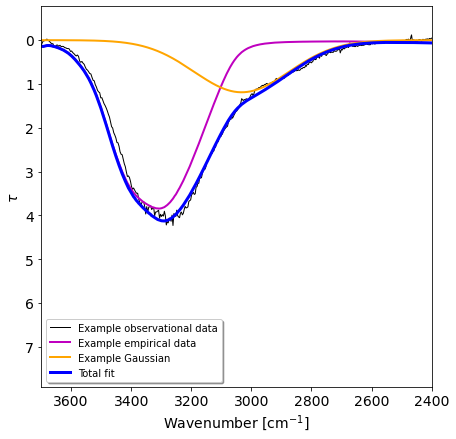

In [29]:
ax = plt.subplots(figsize=(7,7))
fitter_example.plot_fitresults(ax[1])
plt.gca().invert_yaxis()
ax[1].set_xlim(3700.,2400.)
plt.ylabel(r'$\tau$', fontsize='14')
plt.xticks(fontsize='14')
plt.xlabel(r'Wavenumber [cm$^{-1}$]', fontsize='14')
plt.yticks(fontsize='14')

plt.savefig('figures/example_fitres.pdf')